### Imports

In [1]:
#official libraries
import numpy as np
import matplotlib.pyplot as plt
import pylab 
import cmath
import random
from scipy import integrate
from scipy.fftpack import fft
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy import signal
import pandas as pd
import time
import torch.nn as nn
import torch.nn.functional as F
import time 
import visdom
from os.path import expanduser

In [2]:
#own files
from lib.utils_general import diff_same_length, get_data_paths
from lib.utils_generate_W import get_grid, gauss_dist, generate_W
from lib.utils_generate_n import n_compl, plot_n
from lib.utils_calc_psi import plot_psi
from lib.utils_generate_data import generate_init_data, generate_init_data_diverse, \
                                    plot_sample, generate_corr_data, generate_init_data_diverse_onlyk1
from lib.utils_initial_dataset import InitialDataset, ToTensor, OneChannel, Normalize, calc_mean_std
from lib.utils_train import get_dataloaders, train_net
from lib.nets import FNN, UNet
from lib.utils_evaluation import DeNorm, plot_prediction, plot_correction
from lib.utils_corrector_dataset import CorrectorDataset, NormalizeCorr, calc_mean_std_corr, ToDevice
from lib.utils_train_corrector import train_corrector
from lib.UNet_featurek import UNet_featurek
from lib.LSTM import LSTM
from lib.plot_intensity_bars import plot_intensity_bars
from lib.LSTMFFout import LSTMFFout

In [3]:
torch.cuda.is_available()

True

### Parameter, paths, etc

In [15]:
# ---------------------------------
# choose which mode the prg is in:
# ---------------------------------
do_load_model = True
#do_load_model_corr = False
do_train_model = False  # not do_load_model
#do_train_model_corr = not do_load_model_corr
do_create_initial_data = False
do_create_test_data = True
#do_create_corrector_data = True
toy_data = False #if run on GPU machine, set to false
which_model = 'LSTM_k1' #FNN / UNet / UNet_old / UNet_featurek / LSTM
#which_model_corr = 'UNet'
# ---------------------------------

# ---------------------------------
# paths:
# ---------------------------------
home = expanduser("~")

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# models
path_model = 'models/' + which_model + '.pt'
path_model_corr = 'models/' + which_model + '_corr.pt'

# data
path_initial_data, path_corrector_data = get_data_paths(toy_data, device, home)

path_initial_data_diverse = home + '/ml_data/data_initial_diverse_onlyk1/'
path_test_data = home + '/ml_data/data_test_onlyk1/'

# plots
path_plots = 'plots/'
# ---------------------------------

# ---------------------------------
# hyperparameters:
# ---------------------------------
learning_rate = 0.0001 # for UNet: 0.000001
nmbr_epochs = 100
early_stopping = 100
validation_split = 0.2
# ---------------------------------

# ---------------------------------
# data parameters:
# ---------------------------------
half_width = 5
nmbr_points = 10000
if toy_data:
    size_dataset = 8 #if run on GPU machine, set to 5000 (toydata 8)
else:
    size_dataset = 10000

grid, stepsize = get_grid(half_width, nmbr_points)
# ---------------------------------

### Generate Initial Data

In [12]:
if do_create_initial_data:
    generate_init_data_diverse_onlyk1(size_dataset, path = path_initial_data_diverse, x = grid, dx = stepsize)

7284


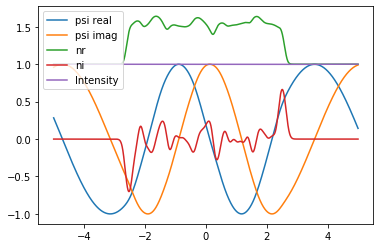

In [6]:
#show that it worked
plot_sample(size_dataset, path = path_initial_data_diverse, x = grid, dx = stepsize)

### Create Initial Dataset

In [7]:
nr_mean, nr_std, ni_mean, ni_std = calc_mean_std(size_dataset, path_initial_data_diverse)

In [8]:
transform = transforms.Compose([Normalize((nr_mean, ni_mean), (nr_std, ni_std)),
                                    ToTensor(device)
                                   ])

In [9]:
initial_dataset = InitialDataset(csv_file = path_initial_data_diverse + 'k_values.csv', 
                               root_dir = path_initial_data_diverse,
                               transform = transform)

In [10]:
len(initial_dataset)

30000

61
tensor([-1.0337, -1.0337, -1.0337,  ..., -1.0337, -1.0337, -1.0337],
       device='cuda:0')
torch.Size([10001])
True


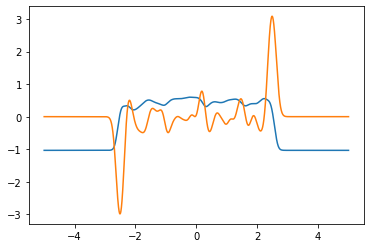

In [11]:
#show that it worked
idx = np.random.randint(64)
print(idx)

print(initial_dataset[idx]['k_n_r'])
print(initial_dataset[idx]['k_n_r'].size())
print(initial_dataset[idx]['k_n_r'].is_cuda)

plt.plot(grid,initial_dataset[idx]['k_n_r'].cpu().numpy()[1:])
plt.plot(grid,initial_dataset[idx]['n_i'].cpu().numpy())    

### Create Dataloaders and Model

In [12]:
train_loader, validation_loader = get_dataloaders(initial_dataset, 
                                                  batch_size = 64, 
                                                  validation_split = validation_split, 
                                                  shuffle_dataset = True, 
                                                  random_seed= 42)

In [16]:
#evtl soll nicht ein neues Model erstellt, sondern ein altes geladen werden!

if do_load_model:
    model = torch.load(path_model, map_location=device) # , map_location=device
else:
    #sonst wird jetzt neues Model erstellt
    if which_model == 'FNN':
        model = FNN(n_feature=10001, n_hidden=1000, n_output=10000)
    elif which_model == 'UNet_featurek':
        model = UNet_featurek(device, n_channels=1, n_classes=1, label_len = nmbr_points)
    elif which_model == 'LSTM':
        #model = LSTM(10, 100, 3, 1000, device)
        model = LSTM(10, 200, 3, 1000, device)
    else:
        model = UNet(n_channels=1, n_classes=1, label_len = nmbr_points)

print(model)

LSTM(
  (lstm): LSTM(11, 200, num_layers=3, batch_first=True)
  (fc): Linear(in_features=200, out_features=10, bias=True)
)


In [17]:
model.to(device)
next(model.parameters()).is_cuda

True

### Training

In [46]:
if do_train_model:
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model, info = train_net(nmbr_epochs, model, criterion, optimizer,
                            train_loader, validation_loader, early_stopping= early_stopping, path=path_model)

[1,     1] loss: 7.754 runtime: 0.194355
[1,    11] loss: 82.796 runtime: 2.127142
[1,    21] loss: 78.178 runtime: 4.054229
[1,    31] loss: 76.624 runtime: 5.945750
[1,    41] loss: 76.879 runtime: 7.892950
[1,    51] loss: 73.905 runtime: 9.833503
[1,    61] loss: 72.561 runtime: 11.781277
[1,    71] loss: 75.909 runtime: 13.657182
[1,    81] loss: 76.225 runtime: 15.531445
[1,    91] loss: 71.544 runtime: 17.423623
[1,   101] loss: 70.049 runtime: 19.303397
[1,   111] loss: 68.214 runtime: 21.218571
[1,   121] loss: 68.888 runtime: 23.134416
[1,   131] loss: 63.198 runtime: 25.065021
[1,   141] loss: 54.069 runtime: 27.011660
[1,   151] loss: 50.105 runtime: 28.997990
[1,   161] loss: 44.754 runtime: 31.004637
[1,   171] loss: 40.462 runtime: 32.978979
[1,   181] loss: 38.831 runtime: 34.920896
[1,   191] loss: 35.397 runtime: 36.828773
[1,   201] loss: 33.727 runtime: 38.724810
[1,   211] loss: 33.955 runtime: 40.621132
[1,   221] loss: 31.795 runtime: 42.494422
[1,   231] loss: 3

[5,   311] loss: 7.746 runtime: 501.819953
[5,   321] loss: 8.389 runtime: 503.652619
[5,   331] loss: 9.663 runtime: 505.434601
[5,   341] loss: 8.742 runtime: 507.214709
[5,   351] loss: 7.613 runtime: 509.001116
[5,   361] loss: 7.082 runtime: 510.782142
[5,   371] loss: 10.133 runtime: 512.573768
Epoch 5 has validation loss 11.8062992197402
[6,     1] loss: 5.683 runtime: 555.557261
[6,    11] loss: 10.423 runtime: 557.360564
[6,    21] loss: 10.785 runtime: 559.147530
[6,    31] loss: 8.638 runtime: 560.947496
[6,    41] loss: 7.303 runtime: 562.730610
[6,    51] loss: 7.342 runtime: 564.542794
[6,    61] loss: 6.726 runtime: 566.394352
[6,    71] loss: 6.848 runtime: 568.261107
[6,    81] loss: 6.718 runtime: 570.106521
[6,    91] loss: 6.790 runtime: 571.912555
[6,   101] loss: 7.329 runtime: 573.720311
[6,   111] loss: 8.660 runtime: 575.555327
[6,   121] loss: 6.818 runtime: 577.343437
[6,   131] loss: 7.175 runtime: 579.124858
[6,   141] loss: 7.593 runtime: 580.905825
[6,   

[10,   251] loss: 2.903 runtime: 1038.278222
[10,   261] loss: 3.622 runtime: 1040.067652
[10,   271] loss: 4.014 runtime: 1041.853423
[10,   281] loss: 4.596 runtime: 1043.639951
[10,   291] loss: 4.000 runtime: 1045.428805
[10,   301] loss: 3.488 runtime: 1047.216383
[10,   311] loss: 3.202 runtime: 1049.010015
[10,   321] loss: 3.112 runtime: 1050.788136
[10,   331] loss: 3.233 runtime: 1052.566829
[10,   341] loss: 2.907 runtime: 1054.351984
[10,   351] loss: 2.935 runtime: 1056.129883
[10,   361] loss: 2.674 runtime: 1057.905605
[10,   371] loss: 3.901 runtime: 1059.692151
Epoch 10 has validation loss 3.893927548794037
[11,     1] loss: 2.151 runtime: 1102.716046
[11,    11] loss: 5.238 runtime: 1104.537199
[11,    21] loss: 5.533 runtime: 1106.329750
[11,    31] loss: 4.910 runtime: 1108.119937
[11,    41] loss: 4.930 runtime: 1109.911526
[11,    51] loss: 3.431 runtime: 1111.751261
[11,    61] loss: 2.906 runtime: 1113.542855
[11,    71] loss: 4.090 runtime: 1115.335381
[11,    

[15,   111] loss: 2.588 runtime: 1560.238256
[15,   121] loss: 2.319 runtime: 1562.035770
[15,   131] loss: 2.873 runtime: 1563.811675
[15,   141] loss: 2.304 runtime: 1565.603041
[15,   151] loss: 2.596 runtime: 1567.396339
[15,   161] loss: 2.556 runtime: 1569.220435
[15,   171] loss: 2.662 runtime: 1571.003983
[15,   181] loss: 2.082 runtime: 1572.796073
[15,   191] loss: 2.624 runtime: 1574.586154
[15,   201] loss: 2.002 runtime: 1576.383682
[15,   211] loss: 2.557 runtime: 1578.176852
[15,   221] loss: 2.428 runtime: 1579.958618
[15,   231] loss: 2.977 runtime: 1581.748315
[15,   241] loss: 2.327 runtime: 1583.519294
[15,   251] loss: 3.018 runtime: 1585.318264
[15,   261] loss: 2.499 runtime: 1587.099007
[15,   271] loss: 2.576 runtime: 1588.891459
[15,   281] loss: 2.869 runtime: 1590.699637
[15,   291] loss: 3.026 runtime: 1592.487763
[15,   301] loss: 2.506 runtime: 1594.268312
[15,   311] loss: 3.966 runtime: 1596.057942
[15,   321] loss: 3.754 runtime: 1597.847594
[15,   331

[19,   371] loss: 1.781 runtime: 2043.791676
Epoch 19 has validation loss 2.456549141635286
[20,     1] loss: 1.071 runtime: 2086.744308
[20,    11] loss: 3.227 runtime: 2088.590424
[20,    21] loss: 4.471 runtime: 2090.449324
[20,    31] loss: 4.808 runtime: 2092.239456
[20,    41] loss: 3.738 runtime: 2094.080253
[20,    51] loss: 2.714 runtime: 2095.911146
[20,    61] loss: 2.964 runtime: 2097.734240
[20,    71] loss: 3.071 runtime: 2099.528186
[20,    81] loss: 3.639 runtime: 2101.309516
[20,    91] loss: 2.653 runtime: 2103.100134
[20,   101] loss: 2.172 runtime: 2104.893512
[20,   111] loss: 2.023 runtime: 2106.689838
[20,   121] loss: 1.763 runtime: 2108.471833
[20,   131] loss: 1.591 runtime: 2110.257446
[20,   141] loss: 1.913 runtime: 2112.039855
[20,   151] loss: 2.092 runtime: 2113.833032
[20,   161] loss: 1.954 runtime: 2115.632252
[20,   171] loss: 2.729 runtime: 2117.417318
[20,   181] loss: 2.362 runtime: 2119.213256
[20,   191] loss: 2.218 runtime: 2121.011966
[20,   2

[24,   241] loss: 2.493 runtime: 2568.573742
[24,   251] loss: 2.562 runtime: 2570.366092
[24,   261] loss: 2.016 runtime: 2572.157371
[24,   271] loss: 1.481 runtime: 2573.951944
[24,   281] loss: 1.548 runtime: 2575.747568
[24,   291] loss: 1.264 runtime: 2577.538163
[24,   301] loss: 1.672 runtime: 2579.324228
[24,   311] loss: 1.516 runtime: 2581.099222
[24,   321] loss: 1.841 runtime: 2582.891124
[24,   331] loss: 1.702 runtime: 2584.680462
[24,   341] loss: 1.508 runtime: 2586.470237
[24,   351] loss: 3.827 runtime: 2588.259604
[24,   361] loss: 2.683 runtime: 2590.046804
[24,   371] loss: 3.244 runtime: 2591.834671
Epoch 24 has validation loss 2.24415570085353
[25,     1] loss: 1.401 runtime: 2634.949269
[25,    11] loss: 1.731 runtime: 2636.753075
[25,    21] loss: 1.670 runtime: 2638.543680
[25,    31] loss: 1.629 runtime: 2640.320872
[25,    41] loss: 1.663 runtime: 2642.112584
[25,    51] loss: 1.502 runtime: 2643.898453
[25,    61] loss: 1.557 runtime: 2645.689720
[25,    7

[29,   111] loss: 1.599 runtime: 3091.172225
[29,   121] loss: 2.290 runtime: 3092.954812
[29,   131] loss: 1.876 runtime: 3094.742205
[29,   141] loss: 1.800 runtime: 3096.600399
[29,   151] loss: 1.448 runtime: 3098.385440
[29,   161] loss: 1.321 runtime: 3100.174971
[29,   171] loss: 1.355 runtime: 3101.953396
[29,   181] loss: 1.365 runtime: 3103.714304
[29,   191] loss: 1.356 runtime: 3105.487610
[29,   201] loss: 1.288 runtime: 3107.291482
[29,   211] loss: 1.553 runtime: 3109.079342
[29,   221] loss: 1.141 runtime: 3110.869008
[29,   231] loss: 1.274 runtime: 3112.655921
[29,   241] loss: 1.377 runtime: 3114.428596
[29,   251] loss: 1.496 runtime: 3116.251245
[29,   261] loss: 2.614 runtime: 3118.186502
[29,   271] loss: 2.129 runtime: 3119.971229
[29,   281] loss: 2.050 runtime: 3121.757012
[29,   291] loss: 1.264 runtime: 3123.535050
[29,   301] loss: 1.319 runtime: 3125.313185
[29,   311] loss: 1.446 runtime: 3127.094238
[29,   321] loss: 1.749 runtime: 3128.876130
[29,   331

[33,   371] loss: 1.040 runtime: 3577.538188
Epoch 33 has validation loss 1.2539296923799714
[34,     1] loss: 0.555 runtime: 3620.479776
[34,    11] loss: 1.111 runtime: 3622.276668
[34,    21] loss: 1.251 runtime: 3624.051750
[34,    31] loss: 1.419 runtime: 3625.840837
[34,    41] loss: 2.116 runtime: 3627.619050
[34,    51] loss: 2.983 runtime: 3629.401941
[34,    61] loss: 2.457 runtime: 3631.184851
[34,    71] loss: 2.202 runtime: 3632.965967
[34,    81] loss: 1.654 runtime: 3634.753324
[34,    91] loss: 2.098 runtime: 3636.554046
[34,   101] loss: 2.592 runtime: 3638.333172
[34,   111] loss: 1.879 runtime: 3640.124210
[34,   121] loss: 1.526 runtime: 3641.899270
[34,   131] loss: 1.263 runtime: 3643.695915
[34,   141] loss: 1.305 runtime: 3645.539123
[34,   151] loss: 1.058 runtime: 3647.319574
[34,   161] loss: 1.008 runtime: 3649.104543
[34,   171] loss: 1.039 runtime: 3650.892692
[34,   181] loss: 1.067 runtime: 3652.713750
[34,   191] loss: 1.537 runtime: 3654.561294
[34,   

[38,   241] loss: 1.044 runtime: 4100.901512
[38,   251] loss: 1.014 runtime: 4102.741679
[38,   261] loss: 1.022 runtime: 4104.593601
[38,   271] loss: 1.006 runtime: 4106.441257
[38,   281] loss: 1.097 runtime: 4108.282726
[38,   291] loss: 0.822 runtime: 4110.124363
[38,   301] loss: 0.851 runtime: 4111.980344
[38,   311] loss: 0.915 runtime: 4113.823474
[38,   321] loss: 1.829 runtime: 4115.661912
[38,   331] loss: 1.734 runtime: 4117.503487
[38,   341] loss: 1.900 runtime: 4119.347196
[38,   351] loss: 1.603 runtime: 4121.180029
[38,   361] loss: 2.128 runtime: 4123.021818
[38,   371] loss: 2.562 runtime: 4124.866481
Epoch 38 has validation loss 10.185137713209112
[39,     1] loss: 5.685 runtime: 4167.861088
[39,    11] loss: 6.393 runtime: 4169.663502
[39,    21] loss: 2.770 runtime: 4171.441289
[39,    31] loss: 1.664 runtime: 4173.229520
[39,    41] loss: 1.510 runtime: 4175.025655
[39,    51] loss: 1.249 runtime: 4176.850491
[39,    61] loss: 1.122 runtime: 4178.640585
[39,   

[43,   111] loss: 0.906 runtime: 4625.514412
[43,   121] loss: 0.733 runtime: 4627.306463
[43,   131] loss: 0.802 runtime: 4629.093211
[43,   141] loss: 0.845 runtime: 4630.887123
[43,   151] loss: 1.626 runtime: 4632.674135
[43,   161] loss: 1.748 runtime: 4634.456308
[43,   171] loss: 1.901 runtime: 4636.238439
[43,   181] loss: 1.269 runtime: 4638.030194
[43,   191] loss: 1.328 runtime: 4639.827340
[43,   201] loss: 1.076 runtime: 4641.616898
[43,   211] loss: 1.115 runtime: 4643.408259
[43,   221] loss: 0.961 runtime: 4645.180030
[43,   231] loss: 0.652 runtime: 4646.950656
[43,   241] loss: 0.715 runtime: 4648.738818
[43,   251] loss: 0.734 runtime: 4650.531077
[43,   261] loss: 0.771 runtime: 4652.321500
[43,   271] loss: 0.745 runtime: 4654.114462
[43,   281] loss: 0.729 runtime: 4655.900597
[43,   291] loss: 0.755 runtime: 4657.694089
[43,   301] loss: 0.802 runtime: 4659.485020
[43,   311] loss: 0.711 runtime: 4661.314438
[43,   321] loss: 0.743 runtime: 4663.096204
[43,   331

[47,   371] loss: 1.346 runtime: 5108.824902
Epoch 47 has validation loss 1.0826646622191087
[48,     1] loss: 0.552 runtime: 5151.949101
[48,    11] loss: 0.922 runtime: 5153.859715
[48,    21] loss: 0.734 runtime: 5155.766605
[48,    31] loss: 1.004 runtime: 5157.667073
[48,    41] loss: 0.927 runtime: 5159.505402
[48,    51] loss: 0.812 runtime: 5161.336336
[48,    61] loss: 0.760 runtime: 5163.178958
[48,    71] loss: 0.747 runtime: 5165.020610
[48,    81] loss: 0.835 runtime: 5166.869081
[48,    91] loss: 0.667 runtime: 5168.699002
[48,   101] loss: 0.664 runtime: 5170.538314
[48,   111] loss: 1.531 runtime: 5172.380010
[48,   121] loss: 1.788 runtime: 5174.257469
[48,   131] loss: 1.283 runtime: 5176.090125
[48,   141] loss: 0.867 runtime: 5177.917881
[48,   151] loss: 0.932 runtime: 5179.743056
[48,   161] loss: 0.888 runtime: 5181.604413
[48,   171] loss: 0.770 runtime: 5183.446807
[48,   181] loss: 0.627 runtime: 5185.296123
[48,   191] loss: 0.557 runtime: 5187.134773
[48,   

[52,   241] loss: 0.982 runtime: 5635.489486
[52,   251] loss: 1.572 runtime: 5637.275273
[52,   261] loss: 1.190 runtime: 5639.056632
[52,   271] loss: 0.905 runtime: 5640.831342
[52,   281] loss: 1.021 runtime: 5642.619129
[52,   291] loss: 0.869 runtime: 5644.417222
[52,   301] loss: 0.678 runtime: 5646.211942
[52,   311] loss: 0.741 runtime: 5648.005220
[52,   321] loss: 0.736 runtime: 5649.792392
[52,   331] loss: 0.727 runtime: 5651.577848
[52,   341] loss: 0.738 runtime: 5653.368725
[52,   351] loss: 0.951 runtime: 5655.149866
[52,   361] loss: 0.886 runtime: 5656.942924
[52,   371] loss: 0.830 runtime: 5658.706130
Epoch 52 has validation loss 0.9137579763823367
[53,     1] loss: 0.395 runtime: 5701.664913
[53,    11] loss: 0.736 runtime: 5703.510247
[53,    21] loss: 0.818 runtime: 5705.310141
[53,    31] loss: 0.838 runtime: 5707.118411
[53,    41] loss: 0.900 runtime: 5708.917607
[53,    51] loss: 0.918 runtime: 5710.719054
[53,    61] loss: 0.803 runtime: 5712.524415
[53,   

[57,   111] loss: 4.641 runtime: 6159.747855
[57,   121] loss: 4.022 runtime: 6161.536113
[57,   131] loss: 3.690 runtime: 6163.330817
[57,   141] loss: 3.574 runtime: 6165.119044
[57,   151] loss: 3.264 runtime: 6166.918856
[57,   161] loss: 3.151 runtime: 6168.707420
[57,   171] loss: 3.350 runtime: 6170.497049
[57,   181] loss: 3.091 runtime: 6172.282213
[57,   191] loss: 3.055 runtime: 6174.108566
[57,   201] loss: 3.091 runtime: 6175.914948
[57,   211] loss: 3.388 runtime: 6177.819579
[57,   221] loss: 3.245 runtime: 6179.613488
[57,   231] loss: 2.765 runtime: 6181.426528
[57,   241] loss: 2.884 runtime: 6183.276776
[57,   251] loss: 2.972 runtime: 6185.090475
[57,   261] loss: 3.408 runtime: 6186.876090
[57,   271] loss: 2.862 runtime: 6188.663130
[57,   281] loss: 3.114 runtime: 6190.445225
[57,   291] loss: 3.206 runtime: 6192.239796
[57,   301] loss: 2.370 runtime: 6194.023527
[57,   311] loss: 2.929 runtime: 6195.807267
[57,   321] loss: 3.064 runtime: 6197.599327
[57,   331

[61,   371] loss: 1.245 runtime: 6644.283823
Epoch 61 has validation loss 1.1302262260875808
[62,     1] loss: 0.421 runtime: 6687.178962
[62,    11] loss: 0.821 runtime: 6689.081115
[62,    21] loss: 0.866 runtime: 6690.857926
[62,    31] loss: 0.781 runtime: 6692.640579
[62,    41] loss: 0.790 runtime: 6694.430289
[62,    51] loss: 0.806 runtime: 6696.221276
[62,    61] loss: 0.878 runtime: 6697.999249
[62,    71] loss: 1.364 runtime: 6699.820837
[62,    81] loss: 0.810 runtime: 6701.611427
[62,    91] loss: 0.805 runtime: 6703.387938
[62,   101] loss: 0.762 runtime: 6705.164983
[62,   111] loss: 0.721 runtime: 6706.949482
[62,   121] loss: 0.959 runtime: 6708.735403
[62,   131] loss: 1.337 runtime: 6710.527592
[62,   141] loss: 0.891 runtime: 6712.311409
[62,   151] loss: 0.882 runtime: 6714.095518
[62,   161] loss: 0.877 runtime: 6715.884169
[62,   171] loss: 0.711 runtime: 6717.653535
[62,   181] loss: 0.740 runtime: 6719.433791
[62,   191] loss: 0.820 runtime: 6721.212673
[62,   

[66,   241] loss: 0.486 runtime: 7166.972497
[66,   251] loss: 0.504 runtime: 7168.779646
[66,   261] loss: 0.438 runtime: 7170.628425
[66,   271] loss: 0.450 runtime: 7172.448905
[66,   281] loss: 0.499 runtime: 7174.239919
[66,   291] loss: 0.559 runtime: 7176.029520
[66,   301] loss: 0.549 runtime: 7177.815780
[66,   311] loss: 0.533 runtime: 7179.603008
[66,   321] loss: 1.619 runtime: 7181.396477
[66,   331] loss: 2.014 runtime: 7183.179922
[66,   341] loss: 1.294 runtime: 7184.971299
[66,   351] loss: 0.922 runtime: 7186.762270
[66,   361] loss: 0.757 runtime: 7188.545503
[66,   371] loss: 0.722 runtime: 7190.342650
Epoch 66 has validation loss 0.6362508684396745
[67,     1] loss: 0.351 runtime: 7233.483231
[67,    11] loss: 0.746 runtime: 7235.311008
[67,    21] loss: 0.623 runtime: 7237.107114
[67,    31] loss: 0.599 runtime: 7238.888884
[67,    41] loss: 0.566 runtime: 7240.676271
[67,    51] loss: 0.888 runtime: 7242.453723
[67,    61] loss: 0.639 runtime: 7244.246939
[67,   

[71,   111] loss: 0.700 runtime: 7690.354603
[71,   121] loss: 0.488 runtime: 7692.145761
[71,   131] loss: 0.400 runtime: 7693.927887
[71,   141] loss: 0.568 runtime: 7695.714478
[71,   151] loss: 0.592 runtime: 7697.509487
[71,   161] loss: 0.454 runtime: 7699.297585
[71,   171] loss: 0.390 runtime: 7701.063581
[71,   181] loss: 0.525 runtime: 7702.844794
[71,   191] loss: 0.413 runtime: 7704.638382
[71,   201] loss: 0.519 runtime: 7706.419225
[71,   211] loss: 2.490 runtime: 7708.207960
[71,   221] loss: 3.746 runtime: 7709.975178
[71,   231] loss: 2.840 runtime: 7711.759533
[71,   241] loss: 1.633 runtime: 7713.536252
[71,   251] loss: 0.787 runtime: 7715.331397
[71,   261] loss: 0.761 runtime: 7717.123448
[71,   271] loss: 0.699 runtime: 7718.905734
[71,   281] loss: 0.526 runtime: 7720.695983
[71,   291] loss: 0.630 runtime: 7722.489489
[71,   301] loss: 0.613 runtime: 7724.291817
[71,   311] loss: 0.560 runtime: 7726.084106
[71,   321] loss: 0.488 runtime: 7727.858260
[71,   331

[75,   371] loss: 0.471 runtime: 8173.582919
Epoch 75 has validation loss 0.46858600431934316
MODEL SAVED.
[76,     1] loss: 0.189 runtime: 8216.584357
[76,    11] loss: 0.449 runtime: 8218.413520
[76,    21] loss: 0.529 runtime: 8220.218844
[76,    31] loss: 0.574 runtime: 8222.086991
[76,    41] loss: 0.438 runtime: 8223.885682
[76,    51] loss: 0.401 runtime: 8225.674808
[76,    61] loss: 0.327 runtime: 8227.468703
[76,    71] loss: 0.383 runtime: 8229.257940
[76,    81] loss: 0.357 runtime: 8231.074984
[76,    91] loss: 0.458 runtime: 8232.856063
[76,   101] loss: 0.654 runtime: 8234.645558
[76,   111] loss: 0.480 runtime: 8236.435330
[76,   121] loss: 0.565 runtime: 8238.247813
[76,   131] loss: 0.421 runtime: 8240.040343
[76,   141] loss: 0.351 runtime: 8241.833058
[76,   151] loss: 0.319 runtime: 8243.622214
[76,   161] loss: 0.950 runtime: 8245.418371
[76,   171] loss: 0.799 runtime: 8247.209292
[76,   181] loss: 0.607 runtime: 8249.007086
[76,   191] loss: 0.416 runtime: 8250.

[80,   241] loss: 0.441 runtime: 8697.862609
[80,   251] loss: 0.479 runtime: 8699.653958
[80,   261] loss: 0.487 runtime: 8701.435108
[80,   271] loss: 1.100 runtime: 8703.223493
[80,   281] loss: 1.333 runtime: 8705.008649
[80,   291] loss: 0.917 runtime: 8706.795782
[80,   301] loss: 0.752 runtime: 8708.578874
[80,   311] loss: 0.614 runtime: 8710.374143
[80,   321] loss: 0.433 runtime: 8712.158896
[80,   331] loss: 0.476 runtime: 8713.940531
[80,   341] loss: 0.498 runtime: 8715.721463
[80,   351] loss: 0.573 runtime: 8717.512927
[80,   361] loss: 0.407 runtime: 8719.295984
[80,   371] loss: 0.522 runtime: 8721.084784
Epoch 80 has validation loss 0.618637911896122
[81,     1] loss: 0.466 runtime: 8764.038507
[81,    11] loss: 0.941 runtime: 8765.858724
[81,    21] loss: 0.609 runtime: 8767.643465
[81,    31] loss: 0.508 runtime: 8769.481346
[81,    41] loss: 0.727 runtime: 8771.316103
[81,    51] loss: 0.739 runtime: 8773.114032
[81,    61] loss: 0.598 runtime: 8774.977672
[81,    

[85,   111] loss: 0.342 runtime: 9222.888221
[85,   121] loss: 0.359 runtime: 9224.673809
[85,   131] loss: 0.578 runtime: 9226.454042
[85,   141] loss: 0.505 runtime: 9228.246336
[85,   151] loss: 0.438 runtime: 9230.029249
[85,   161] loss: 0.410 runtime: 9231.812649
[85,   171] loss: 0.661 runtime: 9233.678792
[85,   181] loss: 0.371 runtime: 9235.465551
[85,   191] loss: 0.419 runtime: 9237.255767
[85,   201] loss: 0.578 runtime: 9239.049732
[85,   211] loss: 0.623 runtime: 9240.838920
[85,   221] loss: 0.991 runtime: 9242.629487
[85,   231] loss: 0.807 runtime: 9244.421622
[85,   241] loss: 0.876 runtime: 9246.189360
[85,   251] loss: 0.607 runtime: 9247.959003
[85,   261] loss: 0.452 runtime: 9249.721536
[85,   271] loss: 0.588 runtime: 9251.511842
[85,   281] loss: 0.585 runtime: 9253.303698
[85,   291] loss: 0.784 runtime: 9255.091737
[85,   301] loss: 0.715 runtime: 9256.877849
[85,   311] loss: 0.805 runtime: 9258.664159
[85,   321] loss: 0.592 runtime: 9260.503142
[85,   331

[89,   371] loss: 0.293 runtime: 9707.018610
Epoch 89 has validation loss 0.3990016126252234
[90,     1] loss: 0.161 runtime: 9750.018929
[90,    11] loss: 0.341 runtime: 9751.872617
[90,    21] loss: 0.332 runtime: 9753.710428
[90,    31] loss: 0.415 runtime: 9755.487973
[90,    41] loss: 0.365 runtime: 9757.258639
[90,    51] loss: 0.500 runtime: 9759.052865
[90,    61] loss: 0.556 runtime: 9760.844514
[90,    71] loss: 0.886 runtime: 9762.629204
[90,    81] loss: 0.990 runtime: 9764.426275
[90,    91] loss: 0.737 runtime: 9766.219042
[90,   101] loss: 1.124 runtime: 9767.996967
[90,   111] loss: 1.022 runtime: 9769.773309
[90,   121] loss: 0.801 runtime: 9771.565069
[90,   131] loss: 0.615 runtime: 9773.357758
[90,   141] loss: 0.463 runtime: 9775.144770
[90,   151] loss: 0.472 runtime: 9776.935843
[90,   161] loss: 0.337 runtime: 9778.725625
[90,   171] loss: 0.299 runtime: 9780.515835
[90,   181] loss: 0.276 runtime: 9782.313629
[90,   191] loss: 0.301 runtime: 9784.111668
[90,   

[94,   221] loss: 0.274 runtime: 10227.864655
[94,   231] loss: 0.269 runtime: 10229.646932
[94,   241] loss: 0.258 runtime: 10231.437453
[94,   251] loss: 0.333 runtime: 10233.194092
[94,   261] loss: 0.264 runtime: 10234.981050
[94,   271] loss: 0.282 runtime: 10236.771836
[94,   281] loss: 0.319 runtime: 10238.545563
[94,   291] loss: 0.278 runtime: 10240.320196
[94,   301] loss: 0.336 runtime: 10242.102756
[94,   311] loss: 0.399 runtime: 10243.893728
[94,   321] loss: 0.318 runtime: 10245.678278
[94,   331] loss: 0.274 runtime: 10247.446849
[94,   341] loss: 0.264 runtime: 10249.223880
[94,   351] loss: 0.248 runtime: 10251.027318
[94,   361] loss: 0.286 runtime: 10252.819505
[94,   371] loss: 0.335 runtime: 10254.626585
Epoch 94 has validation loss 0.32525726938818367
MODEL SAVED.
[95,     1] loss: 0.174 runtime: 10297.576319
[95,    11] loss: 0.423 runtime: 10299.451077
[95,    21] loss: 0.472 runtime: 10301.273588
[95,    31] loss: 0.352 runtime: 10303.062602
[95,    41] loss: 

[99,    41] loss: 4.198 runtime: 10741.335963
[99,    51] loss: 3.495 runtime: 10743.127633
[99,    61] loss: 2.297 runtime: 10744.917607
[99,    71] loss: 2.390 runtime: 10746.704322
[99,    81] loss: 2.269 runtime: 10748.489446
[99,    91] loss: 1.577 runtime: 10750.274607
[99,   101] loss: 1.013 runtime: 10752.060330
[99,   111] loss: 0.570 runtime: 10753.847771
[99,   121] loss: 0.562 runtime: 10755.636017
[99,   131] loss: 0.861 runtime: 10757.437129
[99,   141] loss: 0.473 runtime: 10759.223831
[99,   151] loss: 0.427 runtime: 10761.012740
[99,   161] loss: 0.358 runtime: 10762.804687
[99,   171] loss: 0.347 runtime: 10764.619808
[99,   181] loss: 0.341 runtime: 10766.411622
[99,   191] loss: 0.292 runtime: 10768.203402
[99,   201] loss: 0.287 runtime: 10769.993176
[99,   211] loss: 0.412 runtime: 10771.780608
[99,   221] loss: 0.289 runtime: 10773.562039
[99,   231] loss: 0.273 runtime: 10775.349223
[99,   241] loss: 0.278 runtime: 10777.126349
[99,   251] loss: 0.297 runtime: 1

In [47]:
print(info)

{'lowest loss': 0.24490825681293266, 'last epoch': 100}


### Evaluation

In [18]:
plt.rcParams['figure.figsize'] = [15,10]

In [19]:
model.eval()

LSTM(
  (lstm): LSTM(11, 200, num_layers=3, batch_first=True)
  (fc): Linear(in_features=200, out_features=10, bias=True)
)

The prediction looks like this...

0.9999999810864295


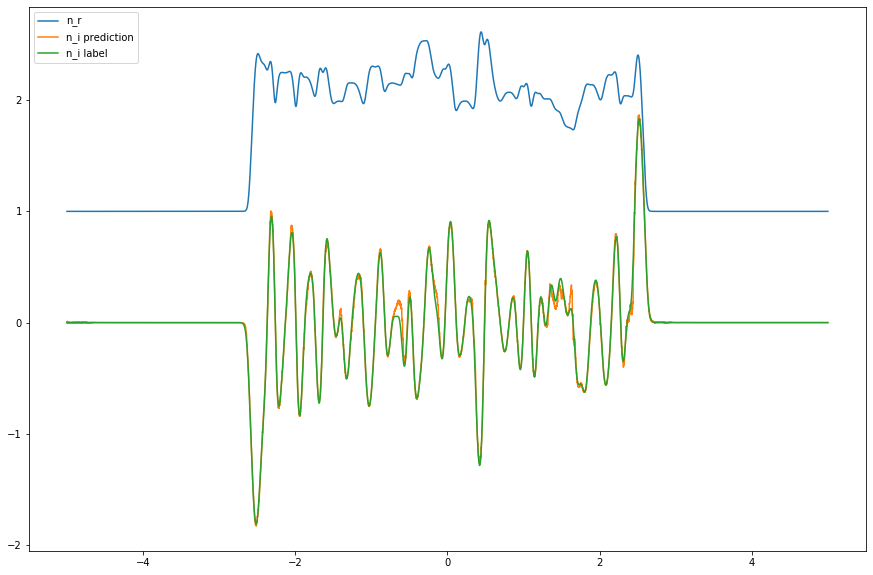

In [25]:
nr, ni, ni_pred, k = plot_prediction(validation_loader, model, grid, 
                                     nr_mean, nr_std, ni_mean, ni_std, 
                                     idx=0, k=None)
plt.savefig(path_plots + which_model + '_Prediction.pdf')

The intensity with the label potential like this...

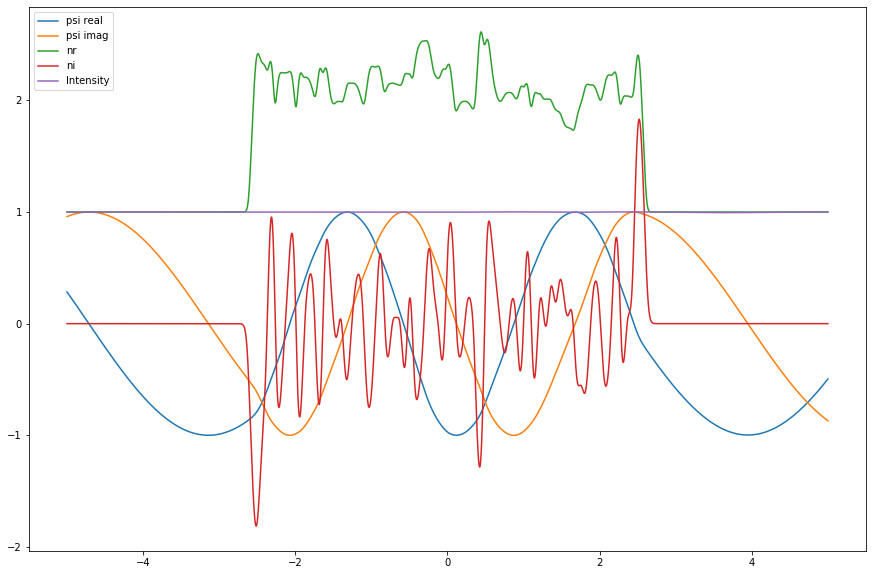

In [26]:
Int = plot_psi(grid, stepsize, n = nr + 1j*ni, Amp = 1, k=k)

And the intensity with the predicted potential like this...

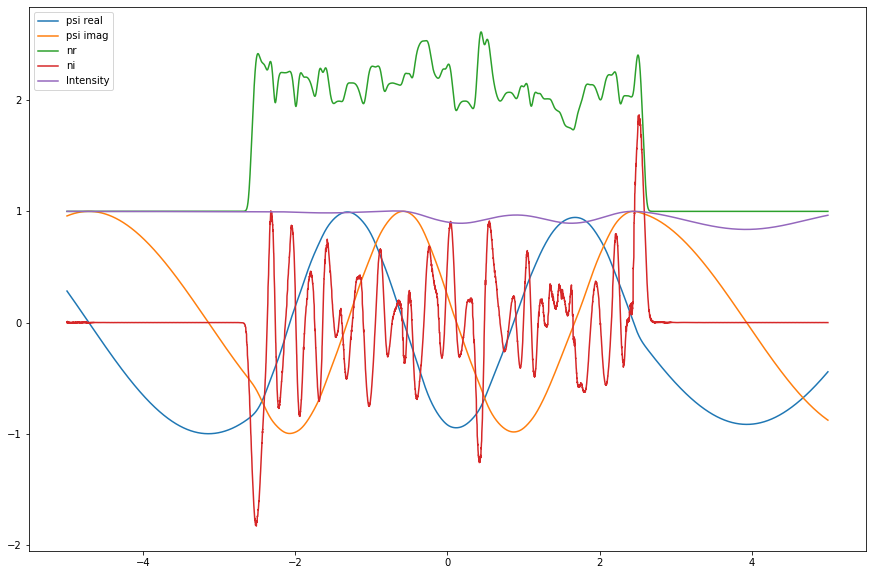

In [27]:
Int_pred = plot_psi(grid, stepsize, n = nr + 1j*ni_pred, Amp = 1, k=k)
plt.savefig(path_plots + which_model + '_CI.pdf')

The differences between the predicted potentials and intensities like this...

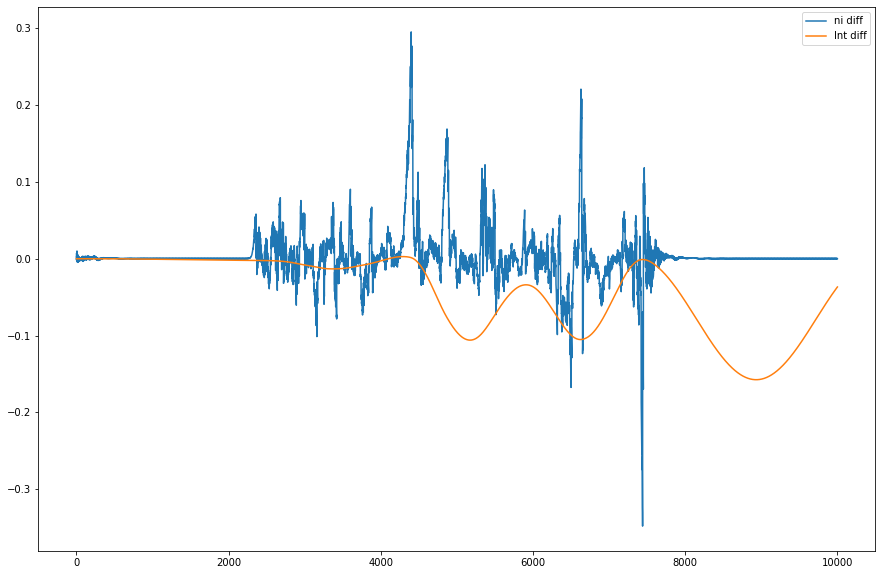

In [28]:
plt.plot(ni_pred-ni, label = 'ni diff')
plt.plot(Int_pred - Int, label = 'Int diff')
plt.legend(loc='upper right')
plt.savefig(path_plots + which_model + '_Diff.pdf')

The label intensity vs the predicted

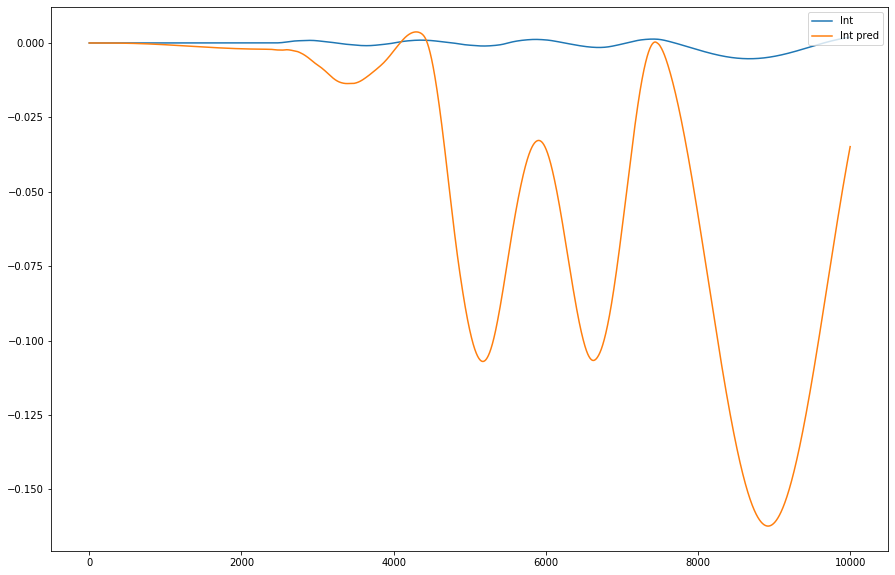

In [29]:
plt.plot(Int -1, label = 'Int')
plt.plot(Int_pred -1, label = 'Int pred')
plt.legend(loc='upper right')

### Special Cases

In [30]:
plt.rcParams['figure.figsize'] = [15,10]

knr:  torch.Size([64, 10001])
ni_pred:  torch.Size([10000])
nr:  torch.Size([10001])
0.9999999810864295


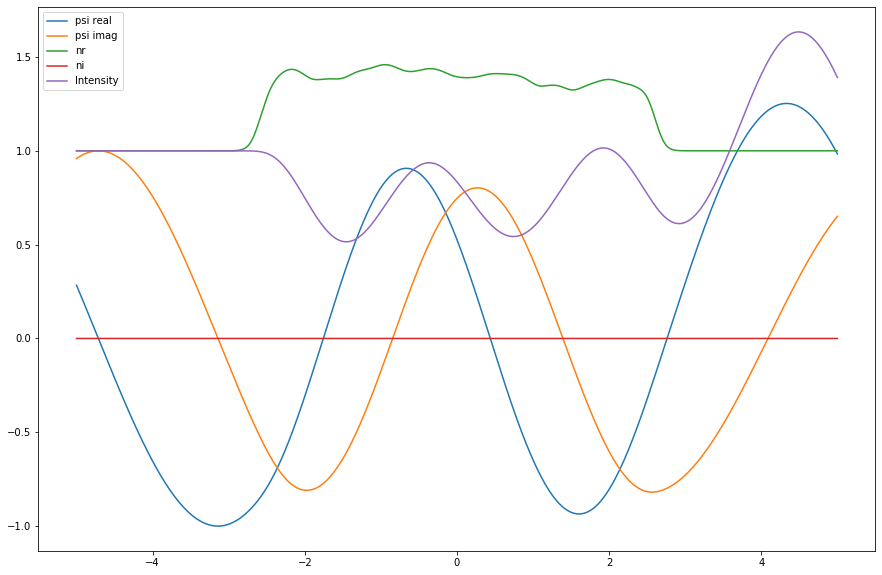

In [31]:
# numerov wave to just nr (what about the intensity? it shouldnt be wave-y)

idx = np.random.randint(8)

item = next(iter(validation_loader))

knr = item['k_n_r']
print('knr: ', knr.size())
ni_pred = model(knr)[idx]
print('ni_pred: ', ni_pred.size())

nr = knr[idx]
print('nr: ', nr.size())

k = DeNorm(knr[idx][0].cpu().numpy(), nr_mean, nr_std)
print(k)
n = DeNorm(nr.cpu().numpy() , nr_mean, nr_std)# + 1j*ni_pred.detach().numpy()
plot_psi(grid, stepsize, n, Amp=1, k=k, plot = True)

plt.savefig(path_plots + '_onlynr.pdf')

### Test

In [89]:
if do_create_test_data:
    generate_init_data_diverse_onlyk1(1000, path = path_test_data, x = grid, dx = stepsize)

Generating Pot Nmbr  0 , Runtime since last:  0.09532356262207031 , Runtime so far:  0.09532332420349121
Generating Pot Nmbr  300 , Runtime since last:  25.8038649559021 , Runtime so far:  25.89918851852417
Generating Pot Nmbr  600 , Runtime since last:  26.107330799102783 , Runtime so far:  52.00652003288269
Generating Pot Nmbr  900 , Runtime since last:  26.228489875793457 , Runtime so far:  78.23501014709473
Generating Pot Nmbr  1200 , Runtime since last:  26.56066870689392 , Runtime so far:  104.79567909240723
Generating Pot Nmbr  1500 , Runtime since last:  25.687330961227417 , Runtime so far:  130.48301076889038
Generating Pot Nmbr  1800 , Runtime since last:  25.207346200942993 , Runtime so far:  155.69035720825195
Generating Pot Nmbr  2100 , Runtime since last:  25.591825485229492 , Runtime so far:  181.28218269348145
Generating Pot Nmbr  2400 , Runtime since last:  26.743263483047485 , Runtime so far:  208.0254464149475
Generating Pot Nmbr  2700 , Runtime since last:  26.31613

In [32]:
nr_mean_test, nr_std_test, ni_mean_test, ni_std_test = calc_mean_std(3000, path_test_data)

In [33]:
transform_test = transforms.Compose([Normalize((nr_mean_test, ni_mean_test), (nr_std_test, ni_std_test)),
                                    ToTensor(device)
                                   ])

In [34]:
initial_dataset_test = InitialDataset(csv_file = path_test_data + 'k_values.csv', 
                                   root_dir = path_test_data,
                                   transform = transform_test)

In [35]:
test_loader, _ = get_dataloaders(initial_dataset_test, 
                                                  batch_size = 6, 
                                                  validation_split = 0, 
                                                  shuffle_dataset = False, 
                                                  random_seed= 42)

2157
0.0033229985274374485


<function matplotlib.pyplot.show(*args, **kw)>

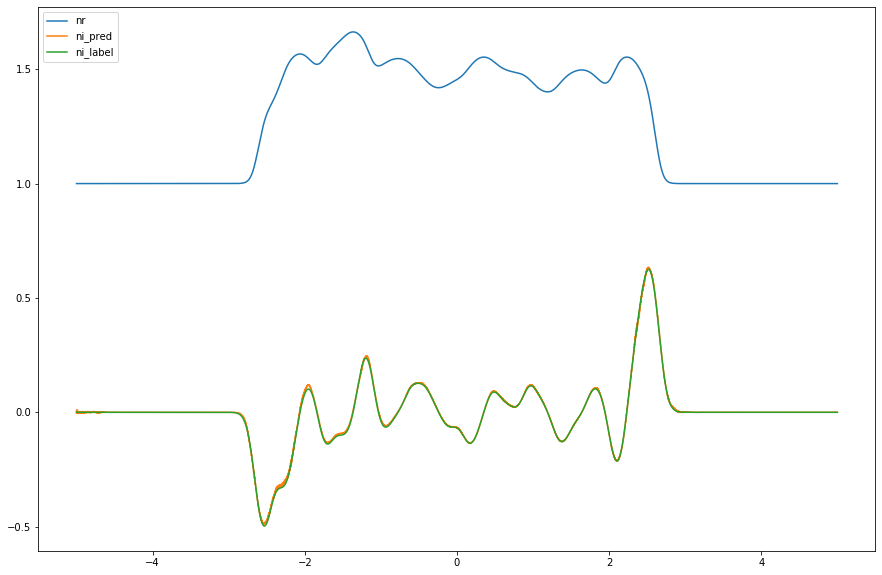

In [59]:
idx = np.random.randint(3000)
print(idx)

data = initial_dataset_test[idx]['k_n_r'].view(1,-1)
out = model(data)
label = initial_dataset_test[idx]['n_i']

criterion = torch.nn.MSELoss()
print(criterion(out[0],label).item() * 8)

plt.plot(grid, DeNorm(data[0][1:].detach().cpu().numpy(),nr_mean_test,nr_std_test), label='nr')
plt.plot(grid, DeNorm(out[0].detach().cpu().numpy(),ni_mean_test,ni_std_test), label = 'ni_pred')
plt.plot(grid, DeNorm(label.detach().cpu().numpy(),ni_mean_test,ni_std_test), label = 'ni_label')
plt.legend(loc='upper left')
plt.show



idx:  2
knr:  tensor([[-1.0334, -1.0334, -1.0334,  ..., -1.0334, -1.0334, -1.0334],
        [-1.0334, -1.0334, -1.0334,  ..., -1.0334, -1.0334, -1.0334],
        [-1.0334, -1.0334, -1.0334,  ..., -1.0334, -1.0334, -1.0334],
        [-1.0334, -1.0334, -1.0334,  ..., -1.0334, -1.0334, -1.0334],
        [-1.0334, -1.0334, -1.0334,  ..., -1.0334, -1.0334, -1.0334],
        [-1.0334, -1.0334, -1.0334,  ..., -1.0334, -1.0334, -1.0334]],
       device='cuda:0')
real k:  0.9999999827768455
new k:  1
knr:  tensor([[-1.0334, -1.0334, -1.0334,  ..., -1.0334, -1.0334, -1.0334],
        [-1.0334, -1.0334, -1.0334,  ..., -1.0334, -1.0334, -1.0334],
        [-1.0334, -1.0334, -1.0334,  ..., -1.0334, -1.0334, -1.0334],
        [-1.0334, -1.0334, -1.0334,  ..., -1.0334, -1.0334, -1.0334],
        [-1.0334, -1.0334, -1.0334,  ..., -1.0334, -1.0334, -1.0334],
        [-1.0334, -1.0334, -1.0334,  ..., -1.0334, -1.0334, -1.0334]],
       device='cuda:0')
max Int:  1.0000000006042498
min Int:  0.97736734342

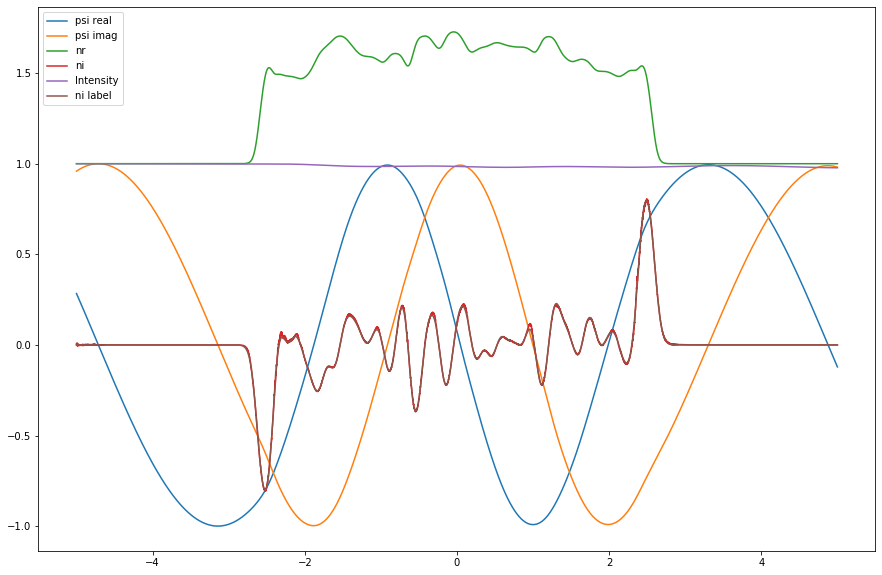

In [104]:
# predict ni for other k - does that work...?

idx = np.random.randint(6)
print('idx: ',idx)

item = next(iter(test_loader))

knr = item['k_n_r']
print('knr: ', knr)

ni = DeNorm(item['n_i'][idx].detach().cpu().numpy(), ni_mean_test, ni_std_test)
k_real = DeNorm(knr[idx][0].detach().cpu().numpy(), nr_mean_test, nr_std_test )
print('real k: ', k_real )

k_new = 1 #np.random.randint(1,11) # np.around(k_real)
print('new k: ', k_new)

knr[:,0] = (k_new - nr_mean_test)/nr_std_test # normalize
print('knr: ',knr)

ni_pred = model(knr)[idx]
#print('ni_pred: ', ni_pred.size())

#print('new k normalized: ',knr[idx][0].cpu().numpy())
k = knr[idx][0].cpu().numpy()
#print('new k: ', k*nr_std + nr_mean)
nr = DeNorm(knr[idx].cpu().numpy(), nr_mean_test, nr_std_test)[1:]
ni_pred = DeNorm(ni_pred.detach().cpu().numpy(), ni_mean_test, ni_std_test)
n = nr + 1j*ni_pred
Int_pred = plot_psi(grid, stepsize, n, Amp=1, k=k_new, plot = True)
#Int_pred = plot_psi(grid, stepsize, n, Amp=1, k=k_real, plot = True)
#plt.plot(grid, ni_pred, label='ni')
plt.plot(grid, ni, label='ni label')
plt.legend(loc='upper left')

plt.savefig(path_plots + which_model + '_differentk.pdf')

print('max Int: ',np.max(Int_pred))
print('min Int: ',np.min(Int_pred))


### Treshold CI Check

In [96]:
# check for all in testset if CI without ni

Amp = 1
Tresh = [0.5,0.2,0.1,0.05,0.03]
over_tresh = np.zeros(len(Tresh))

for j,batch in enumerate(test_loader):
    
    knrs = batch['k_n_r']
    nis = batch['n_i']
    for knr,ni in zip(knrs,nis):
        k = DeNorm(knr[0].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        nr = DeNorm(knr[1:].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        
        Int = plot_psi(grid, stepsize, n=nr, Amp=Amp, k=k, plot = False)
        
        rel_err = np.max((np.abs(Int - Amp)/Amp))
        
        for i,tr in enumerate(Tresh):
            if  rel_err > tr:
                over_tresh[i] += 1
    if j%10 == 0:
        print('{}/{}, {}:{}, {}:{}, {}:{}, {}:{}, {}:{}'.format(
            j,len(test_loader), Tresh[0], over_tresh[0], Tresh[1], over_tresh[1], 
                  Tresh[2], over_tresh[2], Tresh[3], over_tresh[3], Tresh[4], over_tresh[4]))

0/500, 0.5:6.0, 0.2:6.0, 0.1:6.0, 0.05:6.0, 0.03:6.0
10/500, 0.5:66.0, 0.2:66.0, 0.1:66.0, 0.05:66.0, 0.03:66.0
20/500, 0.5:126.0, 0.2:126.0, 0.1:126.0, 0.05:126.0, 0.03:126.0
30/500, 0.5:186.0, 0.2:186.0, 0.1:186.0, 0.05:186.0, 0.03:186.0
40/500, 0.5:245.0, 0.2:246.0, 0.1:246.0, 0.05:246.0, 0.03:246.0
50/500, 0.5:305.0, 0.2:306.0, 0.1:306.0, 0.05:306.0, 0.03:306.0
60/500, 0.5:363.0, 0.2:366.0, 0.1:366.0, 0.05:366.0, 0.03:366.0
70/500, 0.5:423.0, 0.2:426.0, 0.1:426.0, 0.05:426.0, 0.03:426.0
80/500, 0.5:483.0, 0.2:486.0, 0.1:486.0, 0.05:486.0, 0.03:486.0
90/500, 0.5:543.0, 0.2:546.0, 0.1:546.0, 0.05:546.0, 0.03:546.0
100/500, 0.5:603.0, 0.2:606.0, 0.1:606.0, 0.05:606.0, 0.03:606.0
110/500, 0.5:662.0, 0.2:666.0, 0.1:666.0, 0.05:666.0, 0.03:666.0
120/500, 0.5:721.0, 0.2:726.0, 0.1:726.0, 0.05:726.0, 0.03:726.0
130/500, 0.5:781.0, 0.2:786.0, 0.1:786.0, 0.05:786.0, 0.03:786.0
140/500, 0.5:838.0, 0.2:846.0, 0.1:846.0, 0.05:846.0, 0.03:846.0
150/500, 0.5:898.0, 0.2:906.0, 0.1:906.0, 0.05:906.

[0 1 2 3 4 5]
[2973.0, 27.0, 0.0, 0.0, 0.0, 0.0]
['>0.5', '0.2 - 0.5', '0.1 - 0.2', '0.05 - 0.1', '0.03 - 0.05', '<0.03']


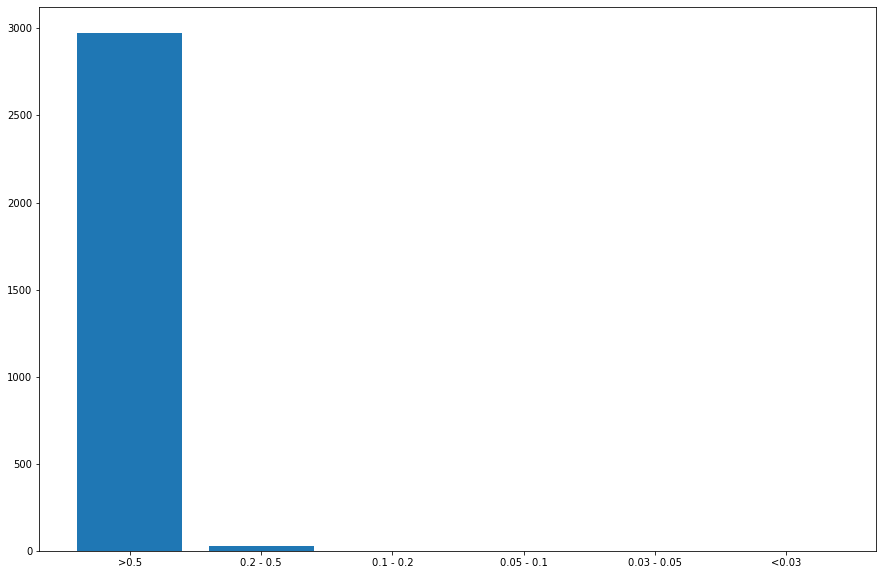

In [97]:
plot_intensity_bars(Tresh, over_tresh, path_plots + 'bars_hermitean.pdf')

In [98]:
# check for all in testset if CI with ni label

Amp = 1
Tresh = [0.5,0.2,0.1,0.05,0.03]
over_tresh = np.zeros(len(Tresh))

for j,batch in enumerate(test_loader):
    
    knrs = batch['k_n_r']
    nis = batch['n_i']
    for knr,ni in zip(knrs,nis):
        k = DeNorm(knr[0].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        
        nr = DeNorm(knr[1:].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        ni = DeNorm(ni.cpu().numpy(), ni_mean_test, ni_std_test)
        
        Int = plot_psi(grid, stepsize, n=nr + 1j*ni, Amp=Amp, k=k, plot = False)
        
        rel_err = np.max((np.abs(Int - Amp)/Amp))
        
        for i,tr in enumerate(Tresh):
            if  rel_err > tr:
                over_tresh[i] += 1
    if j%10 == 0:
        print('{}/{}, {}:{}, {}:{}, {}:{}, {}:{}, {}:{}'.format(
            j,len(test_loader), Tresh[0], over_tresh[0], Tresh[1], over_tresh[1], 
                  Tresh[2], over_tresh[2], Tresh[3], over_tresh[3], Tresh[4], over_tresh[4]))

0/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
10/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
20/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
30/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
40/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
50/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
60/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
70/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
80/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
90/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
100/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
110/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
120/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
130/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
140/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
150/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
160/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
170/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
180/500, 0.5:0.0, 0.2

[0 1 2 3 4 5]
[0.0, 0.0, 0.0, 0.0, 0.0, 3000.0]
['>0.5', '0.2 - 0.5', '0.1 - 0.2', '0.05 - 0.1', '0.03 - 0.05', '<0.03']


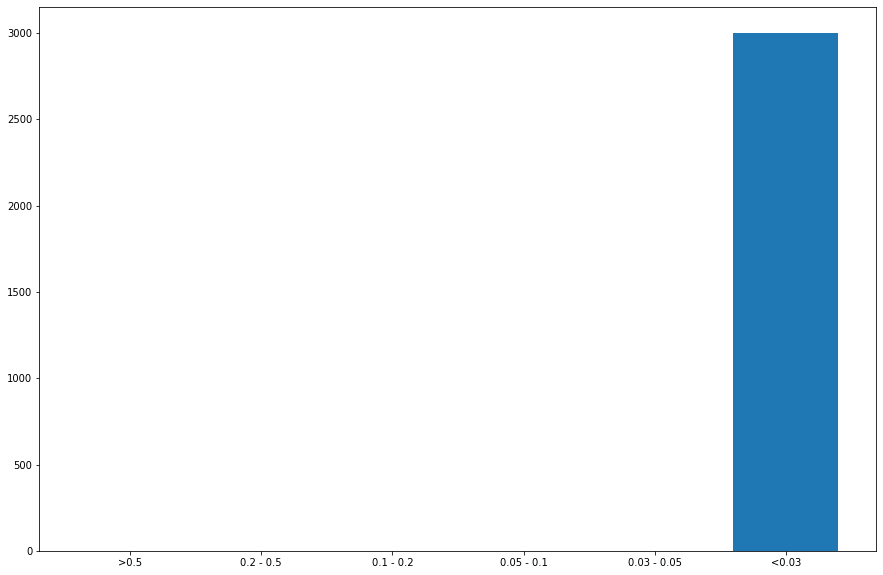

In [99]:
plot_intensity_bars(Tresh, over_tresh, path_plots + 'bars_label.pdf')

In [100]:
# check for all in testset if CI with ni pred

Amp = 1
Tresh = [0.5,0.2,0.1,0.05,0.03]
nipred_over_tresh = np.zeros([len(Tresh), 10]) #tresh, k_real
nipred_how_many_k = np.zeros(10)

for j,batch in enumerate(test_loader):
    
    knrs = batch['k_n_r']
    nis = batch['n_i']
    for knr,ni in zip(knrs,nis):
        k = int(np.around(DeNorm(knr[0].detach().cpu().numpy(), nr_mean_test, nr_std_test)))
        
        nipred_how_many_k[k-1] += 1
        
        ni_pred = model(knr.view(1,-1))[0]
        
        nr = DeNorm(knr[1:].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        ni_pred = DeNorm(ni_pred.detach().cpu().numpy(), ni_mean_test, ni_std_test)
        
        Int_pred = plot_psi(grid, stepsize, n=nr + 1j*ni_pred, Amp=Amp, k=k, plot = False)
        
        rel_err = np.max((np.abs(Int_pred - Amp)/Amp))
        
        for i,tr in enumerate(Tresh):
            if  rel_err > tr:
                nipred_over_tresh[i, k-1] += 1
    if j%10 == 0:
        print('{}/{}, {}:{}, {}:{}, {}:{}, {}:{}, {}:{}'.format(
            j,len(test_loader), np.sum(Tresh[0]), np.sum(nipred_over_tresh[0]), 
            np.sum(Tresh[1]), np.sum(nipred_over_tresh[1]), 
            np.sum(Tresh[2]), np.sum(nipred_over_tresh[2]), 
            np.sum(Tresh[3]), np.sum(nipred_over_tresh[3]), 
            np.sum(Tresh[4]), np.sum(nipred_over_tresh[4])))


0/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:1.0, 0.03:2.0
10/500, 0.5:0.0, 0.2:0.0, 0.1:6.0, 0.05:19.0, 0.03:34.0
20/500, 0.5:0.0, 0.2:2.0, 0.1:17.0, 0.05:46.0, 0.03:76.0
30/500, 0.5:1.0, 0.2:9.0, 0.1:30.0, 0.05:66.0, 0.03:114.0
40/500, 0.5:1.0, 0.2:12.0, 0.1:37.0, 0.05:80.0, 0.03:146.0
50/500, 0.5:1.0, 0.2:12.0, 0.1:45.0, 0.05:102.0, 0.03:188.0
60/500, 0.5:1.0, 0.2:13.0, 0.1:50.0, 0.05:117.0, 0.03:225.0
70/500, 0.5:1.0, 0.2:17.0, 0.1:59.0, 0.05:138.0, 0.03:269.0
80/500, 0.5:1.0, 0.2:20.0, 0.1:64.0, 0.05:154.0, 0.03:304.0
90/500, 0.5:1.0, 0.2:22.0, 0.1:69.0, 0.05:169.0, 0.03:340.0
100/500, 0.5:1.0, 0.2:25.0, 0.1:78.0, 0.05:190.0, 0.03:377.0
110/500, 0.5:1.0, 0.2:28.0, 0.1:84.0, 0.05:205.0, 0.03:409.0
120/500, 0.5:1.0, 0.2:30.0, 0.1:86.0, 0.05:220.0, 0.03:441.0
130/500, 0.5:1.0, 0.2:31.0, 0.1:90.0, 0.05:236.0, 0.03:477.0
140/500, 0.5:1.0, 0.2:31.0, 0.1:98.0, 0.05:257.0, 0.03:516.0
150/500, 0.5:1.0, 0.2:32.0, 0.1:103.0, 0.05:272.0, 0.03:548.0
160/500, 0.5:2.0, 0.2:34.0, 0.1:111.0, 0.05:296.0,

[0 1 2 3 4 5]
[4.0, 78.0, 238.0, 536.0, 925.0, 1219.0]
['>0.5', '0.2 - 0.5', '0.1 - 0.2', '0.05 - 0.1', '0.03 - 0.05', '<0.03']


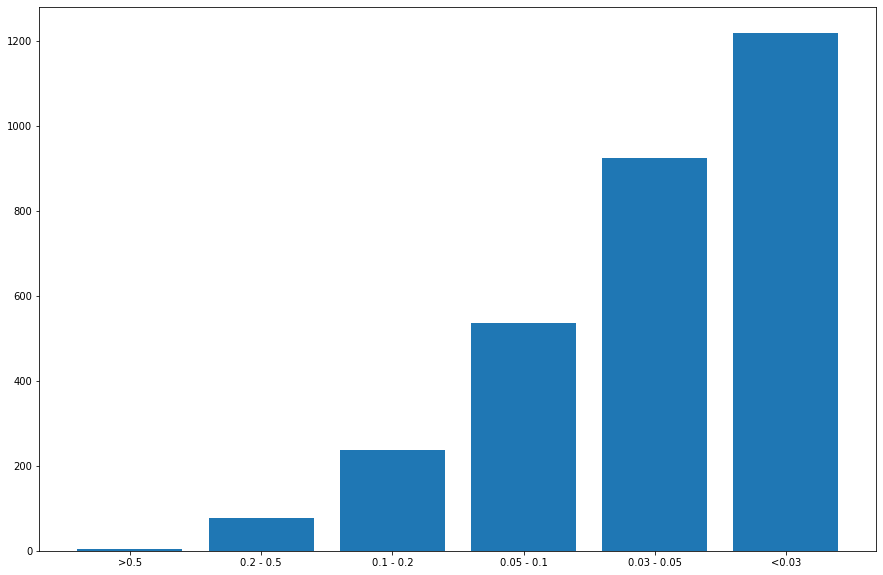

In [101]:
nipred_sum_over_tresh = np.zeros(len(nipred_over_tresh))
for i in range(len(nipred_sum_over_tresh)):
    nipred_sum_over_tresh[i] = int(np.sum(nipred_over_tresh[i]))

plot_intensity_bars(Tresh, nipred_sum_over_tresh, path_plots + which_model + '_bars_prediction.pdf')

0.5 0.010213811454673325
0.2 0.19742765585582386
0.1 0.6585523823398803
0.05 0.9436405532043238
0.03 0.9991150442477876


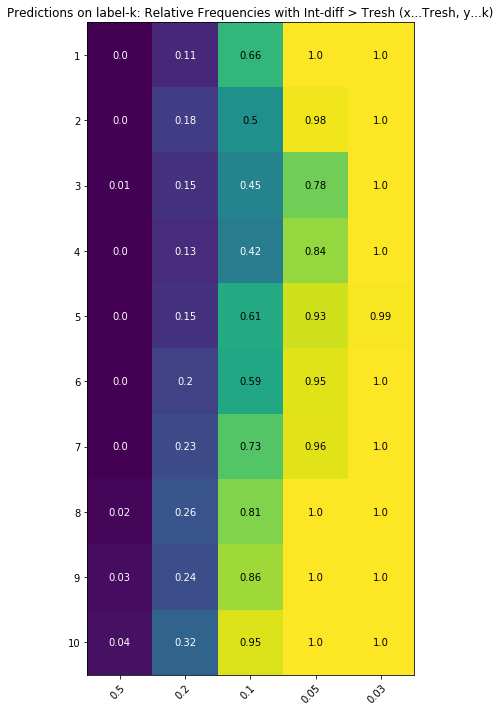

In [47]:
# map for the relative frequencies against the treshhold

k_real = list(range(1,11))

nipred_rel_freq = np.copy(nipred_over_tresh)

for i in range(len(nipred_rel_freq)):
    nipred_rel_freq[i,:] = nipred_rel_freq[i,:]/nipred_how_many_k
    print(Tresh[i], np.mean(nipred_rel_freq[i,:]))
    
nipred_rel_freq = np.transpose(nipred_rel_freq) 

textcolors=["black", "white"]
textcolor_tresh = np.max(nipred_rel_freq)/2

fig, ax = plt.subplots()
im = ax.imshow(nipred_rel_freq)

# We want to show all ticks...
ax.set_xticks(np.arange(len(Tresh)))
ax.set_yticks(np.arange(len(k_real)))
# ... and label them with the respective list entries
ax.set_xticklabels(Tresh)
ax.set_yticklabels(k_real)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(k_real)):
    for j in range(len(Tresh)):
        text = ax.text(j, i, np.around(nipred_rel_freq[i, j], decimals=2),
                       ha="center", va="center",
                       color=textcolors[int(nipred_rel_freq[i,j] < textcolor_tresh)])

ax.set_title("Predictions on label-k: Relative Frequencies with Int-diff > Tresh (x...Tresh, y...k)")
fig.tight_layout()
plt.savefig(path_plots + which_model + '_nipred_RelFreq_gTresh.pdf')
plt.show()

In [48]:
# check for all in testset with random k if CI

Amp = 1
Tresh = [0.5,0.2,0.1,0.05,0.03]
over_tresh = np.zeros([len(Tresh), 10, 10]) #tresh, k_real, k_new
how_many_k = np.zeros([10,10]) # k_real, k_new

for j,batch in enumerate(test_loader):
    
    knrs = batch['k_n_r']
    nis = batch['n_i']
    for knr,ni in zip(knrs,nis):
        
        k_real = int(np.around(DeNorm(knr[0].detach().cpu().numpy(), nr_mean_test, nr_std_test)))
        k_new = np.random.randint(1,11)
        #print(k_real, k_new)
        
        
        how_many_k[k_real-1, k_new-1] += 1        
        
        knr[0] = (k_new - nr_mean_test) / nr_std_test
        ni_pred = model(knr.view(1,-1))[0]
        
        nr = DeNorm(knr[1:].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        ni_pred = DeNorm(ni_pred.detach().cpu().numpy(), ni_mean_test, ni_std_test)
        
        Int_pred = plot_psi(grid, stepsize, n=nr + 1j*ni_pred, Amp=Amp, k=k_new, plot = False)
        
        rel_err = np.max((np.abs(Int_pred - Amp)/Amp))
        
        for i,tr in enumerate(Tresh):
            if  rel_err > tr:
                over_tresh[i, k_real-1, k_new-1] += 1
    if j%10 == 0:
        print('{}/{}, {}:{}, {}:{}, {}:{}, {}:{}, {}:{}'.format(
            j,len(test_loader), np.sum(Tresh[0]), np.sum(over_tresh[0]), 
            np.sum(Tresh[1]), np.sum(over_tresh[1]), 
            np.sum(Tresh[2]), np.sum(over_tresh[2]), 
            np.sum(Tresh[3]), np.sum(over_tresh[3]), 
            np.sum(Tresh[4]), np.sum(over_tresh[4])))
        
    #break

0/500, 0.5:0.0, 0.2:1.0, 0.1:3.0, 0.05:6.0, 0.03:6.0
10/500, 0.5:1.0, 0.2:9.0, 0.1:40.0, 0.05:61.0, 0.03:66.0
20/500, 0.5:1.0, 0.2:27.0, 0.1:84.0, 0.05:118.0, 0.03:126.0
30/500, 0.5:2.0, 0.2:40.0, 0.1:127.0, 0.05:170.0, 0.03:185.0
40/500, 0.5:4.0, 0.2:52.0, 0.1:169.0, 0.05:229.0, 0.03:245.0
50/500, 0.5:4.0, 0.2:63.0, 0.1:208.0, 0.05:286.0, 0.03:305.0
60/500, 0.5:6.0, 0.2:72.0, 0.1:251.0, 0.05:343.0, 0.03:365.0
70/500, 0.5:7.0, 0.2:89.0, 0.1:294.0, 0.05:399.0, 0.03:425.0
80/500, 0.5:8.0, 0.2:103.0, 0.1:334.0, 0.05:456.0, 0.03:484.0
90/500, 0.5:9.0, 0.2:118.0, 0.1:374.0, 0.05:515.0, 0.03:544.0
100/500, 0.5:10.0, 0.2:130.0, 0.1:416.0, 0.05:572.0, 0.03:604.0
110/500, 0.5:10.0, 0.2:143.0, 0.1:451.0, 0.05:628.0, 0.03:664.0
120/500, 0.5:10.0, 0.2:158.0, 0.1:493.0, 0.05:687.0, 0.03:724.0
130/500, 0.5:11.0, 0.2:171.0, 0.1:537.0, 0.05:745.0, 0.03:784.0
140/500, 0.5:13.0, 0.2:182.0, 0.1:581.0, 0.05:803.0, 0.03:844.0
150/500, 0.5:13.0, 0.2:195.0, 0.1:623.0, 0.05:862.0, 0.03:904.0
160/500, 0.5:14.0

[0 1 2 3 4 5]
[50.0, 549.0, 1401.0, 847.0, 150.0, 3.0]
['>0.5', '0.2 - 0.5', '0.1 - 0.2', '0.05 - 0.1', '0.03 - 0.05', '<0.03']


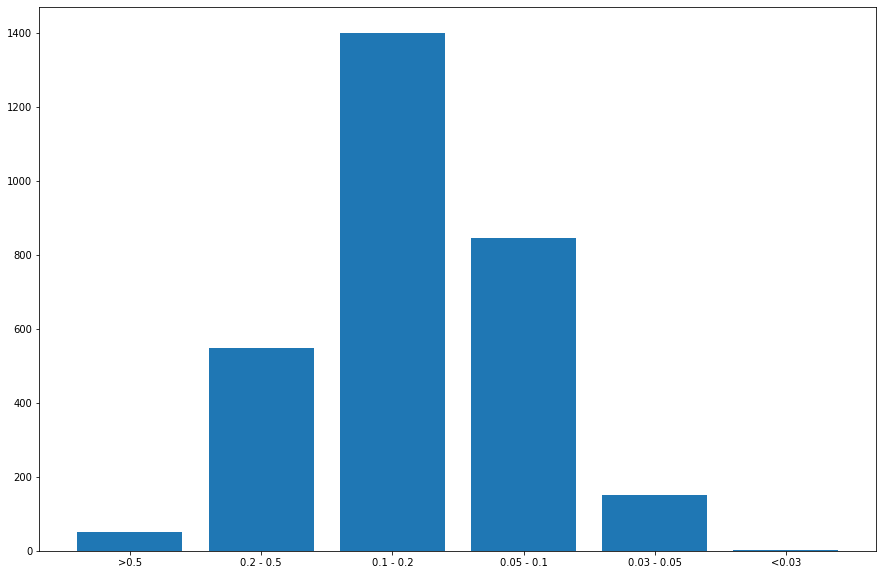

In [49]:
sum_over_tresh = np.zeros(len(over_tresh))
for i in range(len(sum_over_tresh)):
    sum_over_tresh[i] = int(np.sum(over_tresh[i]))

plot_intensity_bars(Tresh, sum_over_tresh, path_plots + which_model + '_bars_differentk.pdf')

2997.0
29.97


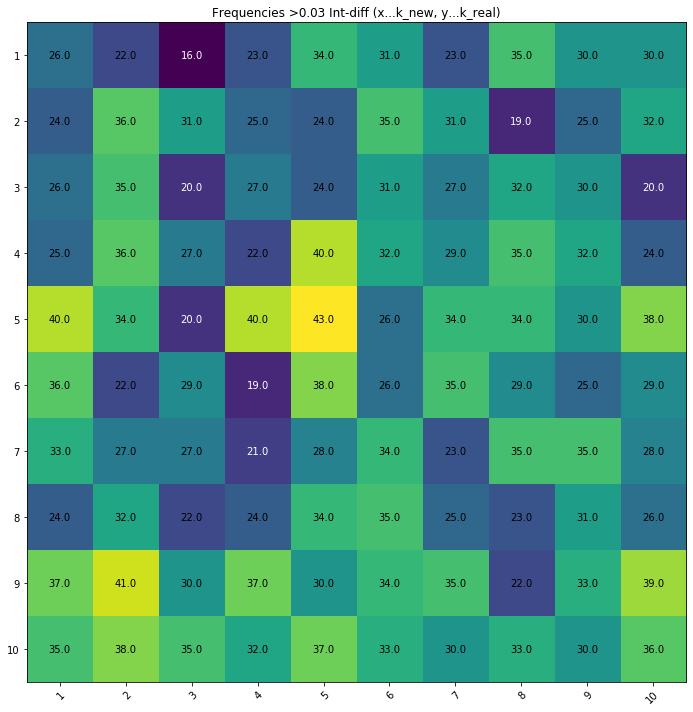

In [50]:
# map for the frequencies

tres_ind = 4

k_real = list(range(1,11))
k_new = list(range(1,11))

freq = over_tresh[tres_ind]
print(np.sum(freq))
print(np.mean(freq))

textcolors=["black", "white"]
textcolor_tresh = np.max(freq)/2

fig, ax = plt.subplots()
im = ax.imshow(freq)

# We want to show all ticks...
ax.set_xticks(np.arange(len(k_new)))
ax.set_yticks(np.arange(len(k_real)))
# ... and label them with the respective list entries
ax.set_xticklabels(k_new)
ax.set_yticklabels(k_real)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(k_real)):
    for j in range(len(k_new)):
        text = ax.text(j, i, freq[i, j],
                       ha="center", va="center",
                       color=textcolors[int(freq[i,j] < textcolor_tresh)])

ax.set_title("Frequencies >{} Int-diff (x...k_new, y...k_real)".format(Tresh[tres_ind]))
fig.tight_layout()
plt.show()

3000.0
30.0


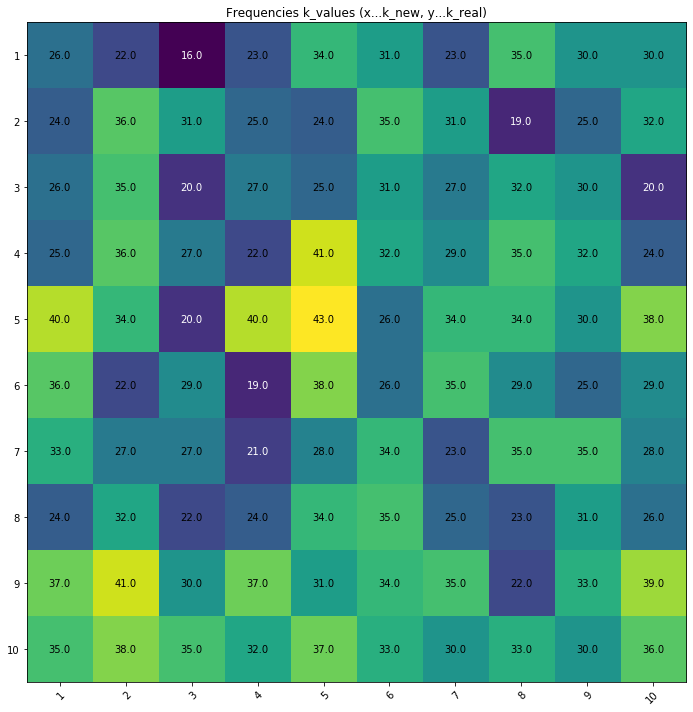

In [51]:
# map for the k values

k_real = list(range(1,11))
k_new = list(range(1,11))

freq_k = how_many_k
print(np.sum(freq_k))
print(np.mean(freq_k))

textcolors=["black", "white"]
textcolor_tresh = np.max(freq_k)/2

fig, ax = plt.subplots()
im = ax.imshow(freq_k)

# We want to show all ticks...
ax.set_xticks(np.arange(len(k_new)))
ax.set_yticks(np.arange(len(k_real)))
# ... and label them with the respective list entries
ax.set_xticklabels(k_new)
ax.set_yticklabels(k_real)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(k_real)):
    for j in range(len(k_new)):
        text = ax.text(j, i, np.around(freq_k[i, j], decimals=2),
                       ha="center", va="center",
                       color=textcolors[int(freq_k[i,j] < textcolor_tresh)])

ax.set_title("Frequencies k_values (x...k_new, y...k_real)")
fig.tight_layout()
plt.show()

2997.0
0.9990335169158143


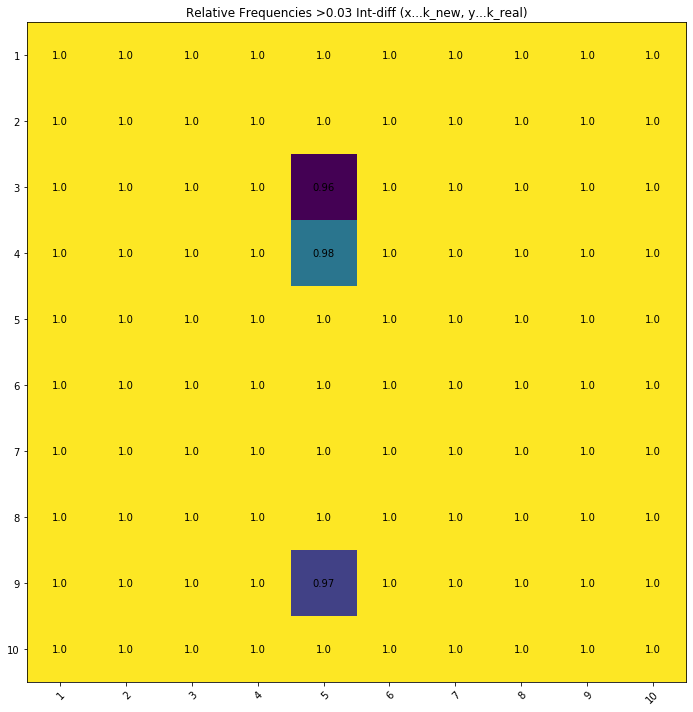

In [56]:
# map for the relative frequencies

tres_ind = 4 # [0.5, 0.2, 0.1, 0.05, 0.03]

k_real = list(range(1,11))
k_new = list(range(1,11))

rel_freq = over_tresh[tres_ind]/how_many_k
print(np.sum(over_tresh[tres_ind]))
print(np.mean(rel_freq))

textcolors=["black", "white"]
textcolor_tresh = np.max(rel_freq)/2

fig, ax = plt.subplots()
im = ax.imshow(rel_freq)

# We want to show all ticks...
ax.set_xticks(np.arange(len(k_new)))
ax.set_yticks(np.arange(len(k_real)))
# ... and label them with the respective list entries
ax.set_xticklabels(k_new)
ax.set_yticklabels(k_real)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(k_real)):
    for j in range(len(k_new)):
        text = ax.text(j, i, np.around(rel_freq[i, j], decimals=2),
                       ha="center", va="center",
                       color=textcolors[int(rel_freq[i,j] < textcolor_tresh)])

ax.set_title("Relative Frequencies >{} Int-diff (x...k_new, y...k_real)".format(Tresh[tres_ind]))
fig.tight_layout()
plt.savefig(path_plots + which_model + '_RelFreq_Int_' + str(Tresh[tres_ind]) + '.pdf')
plt.show()